In [34]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Basics Neural Network

In [35]:
class Model(nn.Module): 
    def __init__(self, layers, activation_functions):
        """Layers is a list containing the number of neurons in each layer.
        Activation_functions is a list of activation functions to be used between layers.
        Nn which contains the description of the neural network."""
        self.layers=layers
        self.activation_functions=activation_functions
        self.Nn=[]
        super(Model, self).__init__()
        for i in range(len(layers) - 1):
            self.Nn.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(activation_functions):
                if activation_functions[i] == 'relu':
                    self.Nn.append(nn.ReLU())
                elif activation_functions[i] == 'sigmoid':
                    self.Nn.append(nn.Sigmoid())
                elif activation_functions[i] == 'normal':
                    self.Nn.append(nn.Identity())
                # Add more activation functions as needed
        self.Nn = nn.Sequential(*self.Nn)   
    def forward(self, x):
        out = self.Nn(x)
        return out
    
        

"""Train-Test Routine and data treatment as a class """
class Train_Test_Routine():
    def __init__(self, model, loss_criterion, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = th.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        if loss_criterion == 'MSE':
            self.criterion = nn.MSELoss()
        elif loss_criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        elif loss_criterion == 'MAE':
            self.criterion = nn.L1Loss()
        elif loss_criterion == 'Huber':
            self.criterion = nn.SmoothL1Loss()  
        elif loss_criterion == 'NLL':
            self.criterion = nn.NLLLoss()
    def data_attributes(self, data):
        self.X=data[:,:-1]
        self.Y=data[:,-1]
        self.n_samples, self.n_features = self.X.shape
    def Numpy_to_Tensor(self, X, Y):
        self.X = th.tensor(X, dtype=th.float32)
        self.Y = th.tensor(Y, dtype=th.float32)
    def normalize_data(self):
        """Normalize features to have mean 0 and std 1"""
        self.X_mean = self.X.mean(dim=0)
        self.X_std = self.X.std(dim=0)
        self.Y_mean = self.Y.mean()
        self.Y_std = self.Y.std()
        self.X = (self.X - self.X_mean) / (self.X_std + 1e-8)
        self.Y = (self.Y - self.Y_mean) / (self.Y_std + 1e-8)
    def train_test_split(self, X, Y, test_size,random_state):
        # Implement train-test split logic here
        self.x_train,self.x_test,self.y_train,self.y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    def train_validation_split(self, X, Y, Validation_size,random_state):
        # Implement train-validation split logic here
        self.x_train,self.x_val,self.y_train,self.y_val = train_test_split(self.x_train, self.y_train, test_size=Validation_size, random_state=random_state)
    def train(self, x_train, y_train,n_wait,batch_size,min_delta):
        """In the training part, this code will use the early syopping technique to avoid overfitting with a patience parameter define by the user."""
        epochs=0
        self.model.n_wait=n_wait
        dataset_train=TensorDataset(x_train,y_train)
        dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
        self.loss_train={} # Dictionary to store training losses
        self.loss_val={}   # Dictionary to store validation losses
        self.min_delta = min_delta
        self.patience_counter = 0
        while epochs<10000000:
            epochs+=1
            for x_batch,y_batch in dataloader_train:
                self.optimizer.zero_grad()
                outputs = self.model(x_batch).reshape(-1)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
            # Validation step and early stopping check
            self.loss_train["Epoch" + str(epochs)] = loss.item()
            outputs_val = self.model(self.x_val).reshape(-1)
            loss_val = self.criterion(outputs_val, self.y_val)
            self.loss_val["Epoch" + str(epochs)] = loss_val.item()
            with th.no_grad():
                if epochs == 1:
                    self.best_loss = loss_val
                elif th.abs(loss_val-self.best_loss)>= self.min_delta:
                    self.best_loss = loss_val
                    self.bestmodel = self.model.state_dict()
                    self.patience_counter = 0
                else:
                    self.patience_counter += 1
                if self.patience_counter >= self.model.n_wait:
                    print(f'Early stopping at epoch {epochs}')
                    self.model.load_state_dict(self.bestmodel)
                    break
    def test(self, x_test, y_test):
        self.model.eval()
        with th.no_grad():
            self.outputs_test = self.model(x_test).reshape(-1)
            loss_test = self.criterion(self.outputs_test, y_test)
        return loss_test.mean().item()

Create the dataset

In [36]:
def Heat(U,A,T_hent,Th_sal,T_cent,T_csal):
    """
    This function calculates the heat transfer rate (Q) in a heat exchanger using the 
    Log Mean Temperature Difference (LMTD) method.

    Parameters:
    U : Overall heat transfer coefficient (W/m²K)
    A : Heat transfer area (m²)
    T_hent: Hot fluid inlet temperature (°C)
    Th_sal: Hot fluid outlet temperature (°C)
    T_cent: Cold fluid inlet temperature (°C)
    T_csal: Cold fluid outlet temperature (°C)

    Returns:
    float: Heat transfer rate (Q) in Watts
    """
    # Calculate temperature differences
    delta_T1 = T_hent - T_csal
    delta_T2 = Th_sal - T_cent
    # Calculate LMTD
    LMTD = np.where(delta_T1==delta_T2, delta_T1, (delta_T1 - delta_T2) / np.log(delta_T1 / delta_T2))
    # Calculate heat transfer rate
    Q = U*A* LMTD
    return Q
U=np.random.uniform(low=10, high=50, size=1000)
A=np.random.uniform(low=10, high=500, size=1000)
T_hent=np.random.uniform(low=300, high=450, size=1000)
Th_sal=np.random.uniform(low=120, high=180, size=1000)
T_cent=np.random.uniform(low=25, high=50, size=1000)
T_csal=np.random.uniform(low=150, high=300, size=1000)
Q= Heat(U,A,T_hent,Th_sal,T_cent,T_csal)
data=np.column_stack((U,A,T_hent,Th_sal,T_cent,T_csal,Q))

Create Neural Network

In [37]:
th.manual_seed(41)
Neural_NN=Model(layers=[6,8,9,1], activation_functions=['relu','relu'])
routine=Train_Test_Routine(model=Neural_NN, loss_criterion='MSE', learning_rate=0.001)
routine.data_attributes(data)
routine.Numpy_to_Tensor(routine.X, routine.Y)
routine.normalize_data()  # Normalize the data
routine.train_test_split(routine.X, routine.Y, test_size=0.1, random_state=41)
routine.train_validation_split(routine.x_train, routine.y_train, Validation_size=0.2, random_state=41)
routine.train(routine.x_train, routine.y_train,n_wait=100,batch_size=32,min_delta=0.0001)

Early stopping at epoch 5060


See the evolution of the model

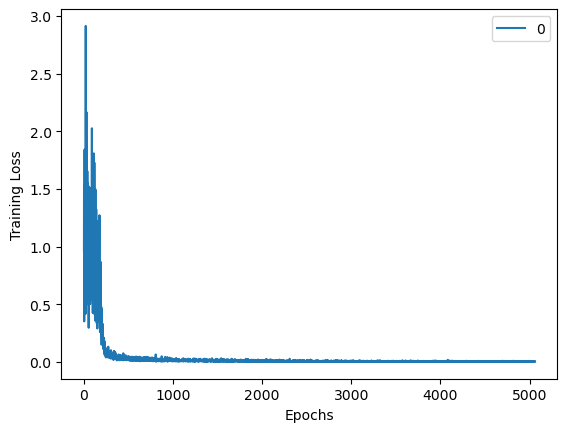

In [38]:
sns.lineplot(routine.loss_train.values())
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [40]:
test=routine.test( routine.x_test, routine.y_test)
print(test)

0.004412887152284384
